In [2]:
import numpy as np
import cv2
import torch
import os
import dataclasses
import IPython
import copy
import sys
import io
import operator
import time
import pathlib
import pickle
import shortuuid
import urllib3
import argparse
import zstandard as zstd
from torch.nn import functional as F
from importlib.machinery import SourceFileLoader
from torch.utils.data import ConcatDataset, DataLoader
from matplotlib import pyplot as plt
from PIL import Image

from simnet.lib import datapoint, realsense_camera, zed_camera
from simnet.lib.net.init.default_init import default_init
from simnet.lib.net import common
from simnet.lib.net.common import prune_state_dict
from simnet.lib.net.models.panoptic_net import PanopticNet
from simnet.lib.datapoint import Stereo 
from simnet.lib.net.dataset import extract_left_numpy_img
from simnet.lib.net.post_processing.depth_outputs import DepthOutput
from simnet.lib.net.post_processing.segmentation_outputs import SegmentationOutput

# Load data from simnet validation set 

Text(0.5, 1.0, 'depth')

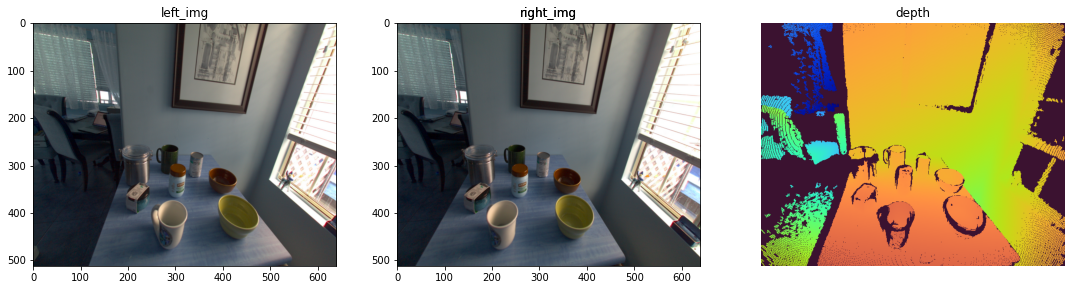

In [3]:
def decompress_datapoint(cbuf, disable_final_decompression=False):
  cctx = zstd.ZstdDecompressor()
  buf = cctx.decompress(cbuf)
  x = pickle.loads(buf)
  if not disable_final_decompression:
    x.decompress()
  return x

def pre_process(stereo_dp):
  height, width, _ = stereo_dp.left_color.shape
  image = np.zeros([height, width, 6], dtype=np.uint8)
  cv2.normalize(stereo_dp.left_color, stereo_dp.left_color, 0, 255, cv2.NORM_MINMAX)
  cv2.normalize(stereo_dp.right_color, stereo_dp.right_color, 0, 255, cv2.NORM_MINMAX)
  image[..., 0:3] = stereo_dp.left_color
  image[..., 3:6] = stereo_dp.right_color
  image = image * 1. / 255.0
  image = image.transpose((2, 0, 1))
  
  # add one more channel  
  image=np.expand_dims(image, axis=0)
  return torch.from_numpy(np.ascontiguousarray(image)).float()

dataset_path="/home/sf3202msi/Documents/allan/simnet/datasets/simnet2021a/val"
stereo = None
get_num =100

for i, path in enumerate(os.listdir(dataset_path)):
    if i< get_num:
        path = f'{dataset_path}/{path}'
        with open(path, 'rb') as fh:
          dp = decompress_datapoint(fh.read())
          stereo = dp.stereo
          left_img=dp.stereo.left_color
          right_img=dp.stereo.right_color
          
          gt_depth=np.expand_dims(dp.depth, axis=0)
          gt_depth=torch.from_numpy(gt_depth).float()
          gt_depth=DepthOutput(gt_depth, None)
            
          segmentation=dp.segmentation
          segmentation=np.expand_dims(dp.segmentation, axis=0)
          segmentation=np.expand_dims(segmentation, axis=0)
          segmentation=torch.from_numpy(segmentation).float()
          segmentation=SegmentationOutput(segmentation, None)
            
            
image_input=pre_process(stereo).cuda()

rows = 1
columns = 4
fig = plt.figure(figsize=(25, 20))

fig.add_subplot(rows, columns, 1)
plt.imshow(left_img)
#plt.axis('off')
plt.title("left_img")
  
fig.add_subplot(rows, columns, 2)
plt.imshow(right_img)
plt.axis('off')
plt.title("right_img")

fig.add_subplot(rows, columns, 2)
plt.imshow(right_img)
#plt.axis('off')
plt.title("right_img")

depth_vis = gt_depth.get_visualization_img(np.copy(left_img))
fig.add_subplot(rows, columns, 3)
plt.imshow(depth_vis)
plt.axis('off')
plt.title("depth")

# Load data from trans_test

(640, 480, 3)
(560, 720, 3)
(512, 640, 3)


Text(0.5, 1.0, 'right_img')

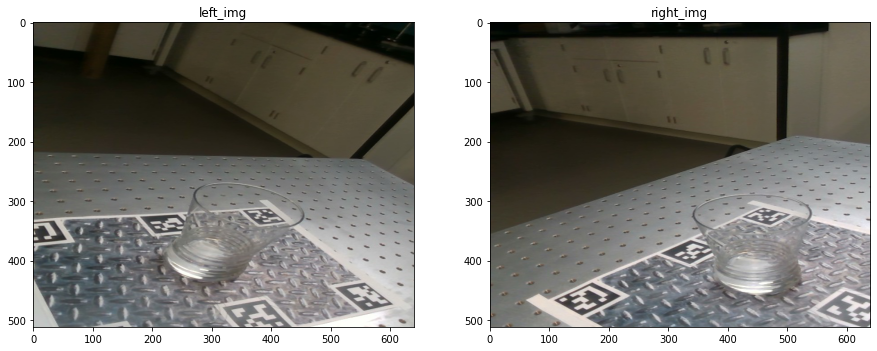

In [51]:
dataset_path="/home/sf3202msi/Documents/allan/simnet/datasets/trans_test/1"
left_img=plt.imread(f'{dataset_path}/1.jpg')
right_img=plt.imread(f'{dataset_path}/2.jpg')
print(left_img.shape)

dim = (720, 560)
left_img = cv2.resize(left_img, dim, interpolation=cv2.INTER_CUBIC)
right_img = cv2.resize(right_img, dim, interpolation=cv2.INTER_CUBIC)
print(left_img.shape)
left_img = left_img[0:512, 0:640]
right_img = right_img[0:512, 0:640]
print(left_img.shape)
trans_stereo = Stereo(left_img, right_img)
image_input=pre_process(trans_stereo).cuda()

rows = 1
columns = 2
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(rows, columns, 1)
plt.imshow(left_img)
plt.title("left_img")
  
fig.add_subplot(rows, columns, 2)
plt.imshow(right_img)
plt.title("right_img")

# Load from rosbag

Transparent Frames Captured


Text(0.5, 1.0, 'right_img')

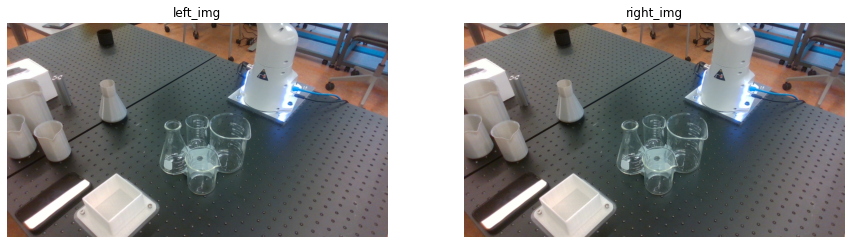

In [4]:
import pyrealsense2 as rs  
pipe_t = rs.pipeline()
cfg_t = rs.config()
cfg_t.enable_device_from_file("/home/sf3202msi/Documents/allan/simnet/datasets/20201107_120125_occlusion_transparent.bag")
profile_t = pipe_t.start(cfg_t)

# Skip first 5 frames to give the Auto-Exposure time to adjust
for x in range(5):
  pipe_t.wait_for_frames()
  
# Store next frameset for later processing:
frameset_t = pipe_t.wait_for_frames()
color_frame_1 = frameset_t.get_color_frame()
color_1 = np.asanyarray(color_frame_1.get_data())

for x in range(20):
  pipe_t.wait_for_frames()

frameset_t = pipe_t.wait_for_frames()
color_frame_2 = frameset_t.get_color_frame()
color_2 = np.asanyarray(color_frame_2.get_data())
"""f1 = frameset_t.get_fisheye_frame(1).as_video_frame()
f2 = frameset_t.get_fisheye_frame(2).as_video_frame()
color_1 = np.asanyarray(f1.get_data())
color_2 = np.asanyarray(f2.get_data())"""

# Cleanup:
pipe_t.stop()
print("Transparent Frames Captured")
        
rows = 1
columns = 2
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(rows, columns, 1)
plt.imshow(color_1)
plt.axis('off')
plt.title("left_img")
  
fig.add_subplot(rows, columns, 2)
plt.imshow(color_2)
plt.axis('off')
plt.title("right_img")

# Load data from Keypose dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 1280, 3)
(560, 720, 3)
(512, 640, 3)


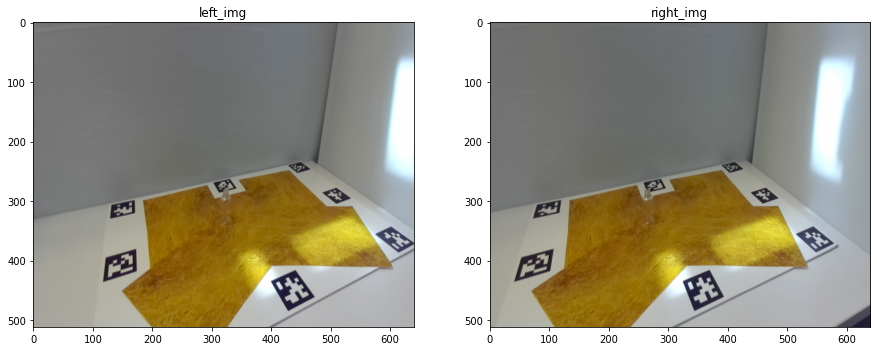

In [4]:
#dataset_path = '/home/sf3202msi/Documents/allan/keypose_data/ball_0/data/ball_0/texture_0_pose_1' #failed
dataset_path ='/home/sf3202msi/Documents/allan/keypose_data/bottle_0/data/bottle_0/texture_3_pose_0'
#dataset_path = '/home/sf3202msi/Documents/allan/keypose_data/mug_5/data/mug_5/texture_9_pose_1'

left_img=plt.imread(f'{dataset_path}/000012_L.png')
right_img=plt.imread(f'{dataset_path}/000012_R.png')
print(left_img.shape)

dim = (720, 560)
left_img = cv2.resize(left_img, dim, interpolation=cv2.INTER_CUBIC)
right_img = cv2.resize(right_img, dim, interpolation=cv2.INTER_CUBIC)
print(left_img.shape)
left_img = left_img[0:512, 0:640]
right_img = right_img[0:512, 0:640]
print(left_img.shape)

rows = 1
columns = 2
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(rows, columns, 1)
plt.imshow(left_img)
plt.title("left_img")
  
fig.add_subplot(rows, columns, 2)
plt.imshow(right_img)
plt.title("right_img")

trans_stereo = Stereo(np.copy(left_img), np.copy(right_img))
image_input=pre_process(trans_stereo).cuda()

# Visualize ground truth depth

(0, 0) - (1279, 719)


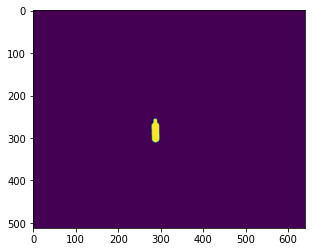

In [9]:
import OpenEXR
import Imath
def exr_loader(EXR_PATH, ndim=3):
    """Loads a .exr file as a numpy array
    Args:
        EXR_PATH: path to the exr file
        ndim: number of channels that should be in returned array. Valid values are 1 and 3.
                        if ndim=1, only the 'R' channel is taken from exr file
                        if ndim=3, the 'R', 'G' and 'B' channels are taken from exr file.
                            The exr file must have 3 channels in this case.
    Returns:
        numpy.ndarray (dtype=np.float32): If ndim=1, shape is (height x width)
                                          If ndim=3, shape is (3 x height x width)
    """

    exr_file = OpenEXR.InputFile(EXR_PATH)
    cm_dw = exr_file.header()['dataWindow']
    print(cm_dw)
    size = (cm_dw.max.x - cm_dw.min.x + 1, cm_dw.max.y - cm_dw.min.y + 1)

    pt = Imath.PixelType(Imath.PixelType.FLOAT)

    if ndim == 3:
        # read channels indivudally
        allchannels = []
        for c in ['R', 'G', 'B']:
            # transform data to numpy
            channel = np.frombuffer(exr_file.channel(c, pt), dtype=np.float32)
            channel.shape = (size[1], size[0])
            allchannels.append(channel)

        # create array and transpose dimensions to match tensor style
        exr_arr = np.array(allchannels).transpose((0, 1, 2))
        return exr_arr

    if ndim == 1:
        # transform data to numpy
        channel = np.frombuffer(exr_file.channel('D', pt), dtype=np.float32)
        channel.shape = (size[1], size[0])  # Numpy arrays are (row, col)
        exr_arr = np.array(channel)
        return exr_arr

file="/home/sf3202msi/Documents/allan/keypose_data/bottle_0/data/bottle_0/texture_3_pose_0/000012_Do.exr"
#gt_depth = cv2.imread(file, cv2.IMREAD_ANYCOLOR|cv2.IMREAD_ANYDEPTH)
#print(gt_depth)
gt_depth = exr_loader(file, ndim=1)
vmin = min(gt_depth.min(), gt_depth.min())
vmax = max(gt_depth.max(), gt_depth.max())
dim = (640, 512)
gt_depth = cv2.resize(gt_depth, dim, interpolation=cv2.INTER_CUBIC)
#gt_depth = cv2.rotate(gt_depth, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
gt_depth=np.expand_dims(gt_depth, axis=0)
#plt.imshow(gt_depth[0], cmap='RdBu_r', vmin=vmin, vmax=vmax)

gt_depth=torch.from_numpy(gt_depth).float()
gt_depth=DepthOutput(gt_depth, None)
left_img=torch.from_numpy(np.ascontiguousarray(left_img)).float()
left_image_np = extract_left_numpy_img(left_img)
depth_vis = gt_depth.get_visualization_img(np.copy(left_image_np))
plt.imshow(depth_vis)

img = cv2.imread("/home/sf3202msi/Documents/allan/keypose_data/bottle_0/data/bottle_0/texture_3_pose_0/000012_mask.png", cv2.IMREAD_GRAYSCALE)
dim = (640, 512)
img = cv2.resize(img, dim, interpolation=cv2.INTER_CUBIC)
plt.imshow(img)

# Load model and checkpoints

In [69]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True
torch.manual_seed(123456)

# test on validation set or trans set
input_data=image_input

ckpt_path = '/home/sf3202msi/Documents/allan/simnet/ckpts/epoch=48.ckpt'
model_file = "/home/sf3202msi/Documents/allan/simnet/simnet/lib/net/models/panoptic_net.py"
model_name = 'res_fpn'
hparam_file= "/home/sf3202msi/Documents/allan/simnet/config/net_config.txt"
model_path = (model_file)

parser = argparse.ArgumentParser(fromfile_prefix_chars='@')
common.add_train_args(parser)
hparams = parser.parse_args(['@config/net_config.txt'])

print('Using model class from:', model_path)
net_module = SourceFileLoader(model_name, str(model_path)).load_module()
net_attr = getattr(net_module, model_name)
model = net_attr(hparams)
model.apply(default_init)

print('Restoring from checkpoint:', ckpt_path)
state_dict = torch.load(ckpt_path, map_location='cuda:0')['state_dict']
state_dict = prune_state_dict(state_dict)
model.load_state_dict(state_dict, strict=False)
model.cuda()
model.eval()
global_step= 1


with torch.no_grad():
  seg_output, depth_output, small_depth_output, pose_outputs, box_outputs, keypoint_outputs = model(
        input_data, global_step
  )

Using model class from: /home/sf3202msi/Documents/allan/simnet/simnet/lib/net/models/panoptic_net.py
Restoring from checkpoint: /home/sf3202msi/Documents/allan/simnet/ckpts/epoch=48.ckpt


# Visualization 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'pose_vis')

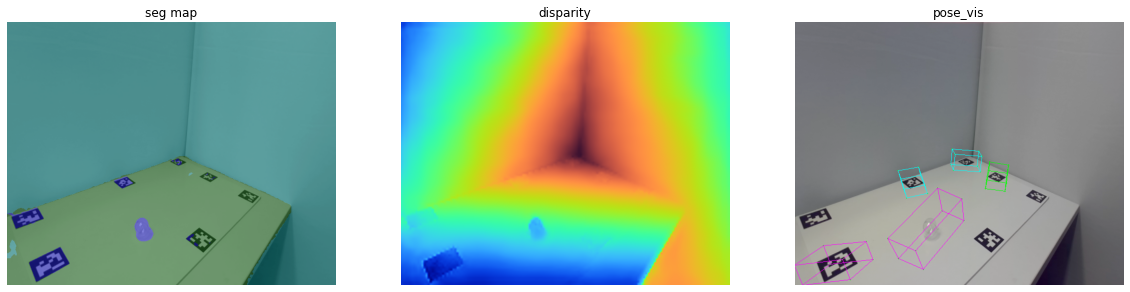

In [70]:
# post-processing
left_image_np = extract_left_numpy_img(input_data[0])
left_img = left_img[...,::-1].copy()
depth_vis = depth_output.get_visualization_img(np.copy(left_image_np))
small_depth_vis = small_depth_output.get_visualization_img(np.copy(left_image_np))
seg_vis = seg_output.get_visualization_img(np.copy(left_image_np))

camera_model =zed_camera.ZEDCamera() # realsense_camera.RSCamera()   # camera.FMKCamera()
pose_vis = pose_outputs.get_visualization_img(np.copy(left_img), camera_model=camera_model)

# plotting 
rows = 1
columns = 3
fig = plt.figure(figsize=(20, 20))

fig.add_subplot(rows, columns, 1)
plt.imshow(seg_vis)
plt.axis('off')
plt.title("seg map")


fig.add_subplot(rows, columns,2)
plt.imshow(depth_vis)
plt.axis('off')
plt.title("disparity")

  
fig.add_subplot(rows, columns, 3)
plt.imshow(pose_vis)
plt.axis('off')
plt.title("pose_vis")

In [62]:
from google.protobuf.json_format import MessageToDict


def decompose_params(filename):
    item_id = None
    item_name = None
    params = {}
    keyword=['resx', 'resy', 'num_kp', 'fx', 'fy', 'cx', 'cy','baseline']
    with open(filename, "r") as file:
        for line in file:
            line.replace(" ", "")
            for word in keyword:
                if word in line:
                    params[word]=float(line.split(":", 1)[1].strip())
    return params

# keypose dataloader
directory="/home/sf3202msi/Documents/allan/keypose_data" #/bottle_0"
obj_names=[dr for dr in os.listdir(directory)]
obj_name=obj_names[0]
#for obj_name in obj_names:
data_directory=f'{directory}/{obj_name}/data/{obj_name}'
scenes=[dr for dr in os.listdir(data_directory)]
for scene in scenes:
    scene_directory=f'{data_directory}/{scene}'
    ids=[]
    for scene_id in os.listdir(scene_directory):
        if scene_id[:6] not in ids and scene_id[0] == '0':
            ids.append(scene_id[:6])

            filenames_rgb_left = f'{scene_directory}/{id}_L.png'
            filenames_rgb_right = f'{scene_directory}/{id}_R.png'
            filenames_seg_left = f'{scene_directory}/{id}_mask.png'
            filenames_kp_left = f'{scene_directory}/{id}_L.pbtxt'
            filenames_kp_right = f'{scene_directory}/{id}_R.pbtxt'
            filenames_depth = f'{scene_directory}/{id}_Dt.exr'
            fielnames_data_params=f'{scene_directory}/data_params.pbtxt'
        
    params=decompose_params(fielnames_data_params)
    break;
           
        

['000051', '000029', '000032', '000076', '000014', '000061', '000054', '000069', '000074', '000050', '000033', '000047', '000015', '000004', '000062', '000070', '000023', '000018', '000025', '000038', '000020', '000001', '000028', '000041', '000003', '000042', '000068', '000072', '000024', '000040', '000027', '000075', '000058', '000019', '000002', '000016', '000009', '000064', '000007', '000052', '000036', '000073', '000055', '000060', '000026', '000010', '000079', '000077', '000048', '000078', '000066', '000031', '000000', '000057', '000059', '000063', '000053', '000017', '000071', '000012', '000035', '000046', '000021', '000022', '000013', '000034', '000037', '000039', '000065', '000067', '000011', '000045', '000056', '000005', '000044', '000006', '000008', '000049', '000043', '000030']
